<a href="https://colab.research.google.com/github/ulissigroup/amptorch/blob/active_learning/amptorch/active_learning/examples/al_random_relaxation_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install  -q git+https://github.com/ulissigroup/amptorch.git@active_learning
!pip install -q git+https://github.com/mshuaibii/SIMPLE-NN.git
!pip install -q amp-atomistics
!pip install -q --upgrade dftbook

     |████████████████████████████████| 296kB 3.4MB/s 
     |████████████████████████████████| 6.7MB 11.1MB/s 
     |████████████████████████████████| 102kB 14.1MB/s 
     |████████████████████████████████| 2.1MB 53.8MB/s 
     |████████████████████████████████| 12.8MB 256kB/s 
     |████████████████████████████████| 110.5MB 38kB/s 
     |████████████████████████████████| 512kB 51.8MB/s 
     |████████████████████████████████| 3.8MB 53.5MB/s 
  ERROR: Failed building wheel for simple-nn
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
    Running setup.py install for simple-nn ... done
     |████████████████████████████████| 102kB 2.9MB/s 


In [0]:
import sys
import numpy as np
import random
import torch

import ase
from ase.calculators.calculator import Calculator
from ase.calculators.emt import EMT
from ase.calculators.singlepoint import SinglePointCalculator as sp
from ase.build import fcc100, add_adsorbate, molecule
from ase.constraints import FixAtoms
from ase.optimize import BFGS, BFGSLineSearch

from amptorch.active_learning.atomistic_methods import MDsimulate, Relaxation
from amptorch.active_learning.learner import AtomisticActiveLearner
from amptorch.active_learning.query_methods import random_query, max_uncertainty
from amptorch.model import CustomMSELoss

import multiprocessing as mp

import dftbook
dftbook.setup_colab()
from espresso import Espresso

Please be patient. This takes about 30 seconds.
Installing ASE
Installing ase-espresso
Installing pseudopotentials
Renaming pseudopotentials
Almost there, setting environment pseudopotential path
Installing MKL
Getting the GPU pw.x executable
Done installing GPU version of Quantum Espresso
Setup is complete. Please visit https://github.com/jkitchin/dft-book-espresso to find the tutorials.
Installation took 22.4 seconds


In [0]:
from ase.utils.eos import EquationOfState
from ase.build import bulk
energies = []
volumes = []
LC = [3.5, 3.55, 3.6, 3.65, 3.7, 3.75]

for a in LC:
  cu_bulk = bulk('Cu', 'fcc', a=a)

  calc = Espresso(xc='PBE',
              pw=500,
              calculation='scf',
              kpts=[12, 12, 12])

  cu_bulk.set_calculator(calc)

  e = cu_bulk.get_potential_energy()
  energies.append(e)
  volumes.append(cu_bulk.get_volume())


eos = EquationOfState(volumes, energies)
v0, e0, B = eos.fit()
aref=3.6
vref = bulk('Cu', 'fcc', a=aref).get_volume()

copper_lattice_constant = (v0/vref)**(1/3)*aref

/usr/local/lib/python3.6/dist-packages/ase/utils/eos.py:5: UserWarning: Moved to ase.eos
  warnings.warn('Moved to ase.eos')


In [0]:
from ase import Atoms, Atom
import copy

base_calc = Espresso(pw=500.0, 
                calculation='scf',
                kpts=(4,4,1),
                xc='PBE')

slab = fcc100("Cu", a=copper_lattice_constant, size=(2, 2, 3))
ads = molecule("C")
add_adsorbate(slab, ads, 3, offset=(1, 1))
cons = FixAtoms(
    indices=[atom.index for atom in slab if (atom.tag == 3)]
)
slab.set_constraint(cons)
slab.center(vacuum=13.0, axis=2)
slab.set_pbc(True)
slab.wrap(pbc=[True] * 3)
slab.set_calculator(copy.copy(base_calc))
slab.set_initial_magnetic_moments()

images = [slab]

# Define symmetry functions
Gs = {}
Gs["G2_etas"] = np.logspace(np.log10(0.05), np.log10(5.0), num=8)
Gs["G2_rs_s"] = [0] * 8
Gs["G4_etas"] = [0.005, 0.01]
Gs["G4_zetas"] = [1.0, 4.0]
Gs["G4_gammas"] = [+1.0, -1]
Gs["cutoff"] = 5.876798323827276  # EMT asap_cutoff: False

training_params = {
      "al_convergence": {"method": "iter", "num_iterations": 3},
      "samples_to_retrain": 5,
      "Gs": Gs,
      "morse": True,
      "forcetraining": True,
      "cores": 10,
      "optimizer": torch.optim.LBFGS,
      "batch_size": 1000,
      "criterion": CustomMSELoss,
      "num_layers": 3,
      "num_nodes": 20,
      "force_coefficient": 0.04,
      "learning_rate": 1e-1,
      "epochs": 300,
      "test_split": 0,
      "shuffle": False,
      "verbose": 1,
      "filename": "relax_example",
      "file_dir": "./"
}

# Define AL scheme
learner = AtomisticActiveLearner(
    training_data=images,
    training_params=training_params,
    parent_calc=base_calc,
    ensemble=False
)

# Learn the corresponding atomistic method
learner.learn(
    generating_function=Relaxation(
        initial_geometry=images[0].copy(),
        optimizer=BFGS,
        fmax=0.01,
        steps=100,
    ),
    query_strategy=random_query
)

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.0917          5.3958        0.5865     +  0.0926
      2          0.0132          0.2647        0.0015     +  0.1033
      3          0.0010          0.0505        0.0001     +  0.1171
      4          0.0001          0.0162        0.0000     +  0.1338
      5          0.0000          0.0076        0.0000     +  0.1372
      6          0.0000          0.0071        0.0000     +  0.1294
      7          0.0000          0.0067        0.0000     +  0.1307
      8          0.0000          0.0063        0.0000     +  0.1414
      9          0.0000          0.0028        0.0000     +  0.1293
     10          0.0000          0.0017        0.0000     +  0.1120
     11          0.0000          0.0007        0.0000     +  0.0153
     12          0.0000          0.0006        0.0000     +  0.

In [0]:
# Compute the parent calculator (DFT) based relaxation

true_relax = Relaxation(slab, BFGS, fmax=0.01)
true_relax.run(base_calc, 'true_relax')
emt_relax = true_relax.get_trajectory('true_relax', 0, -1, 1)

      Step     Time          Energy         fmax
BFGS:    0 17:47:51   -66067.814979        1.3942
BFGS:    1 17:49:12   -66067.857783        1.4564
BFGS:    2 17:50:47   -66067.946623        1.5722
BFGS:    3 17:52:15   -66068.040737        1.6931
BFGS:    4 17:53:41   -66068.140764        1.8248
BFGS:    5 17:55:02   -66068.247238        1.9566
BFGS:    6 17:56:33   -66068.360795        2.0987
BFGS:    7 17:58:01   -66068.481943        2.2458
BFGS:    8 17:59:38   -66068.610855        2.3891
BFGS:    9 18:01:16   -66068.747826        2.5430
BFGS:   10 18:02:59   -66068.892805        2.6768
BFGS:   11 18:04:40   -66069.046212        2.8151
BFGS:   12 18:07:21   -66069.207145        2.9406
BFGS:   13 18:09:17   -66069.374087        3.0398
BFGS:   14 18:11:13   -66069.544569        3.0892
BFGS:   15 18:13:05   -66069.715563        3.0814
BFGS:   16 18:15:09   -66069.882315        3.0018
BFGS:   17 18:17:03   -66070.038660        2.8222
BFGS:   18 18:18:33   -66070.177000        2.5185
B

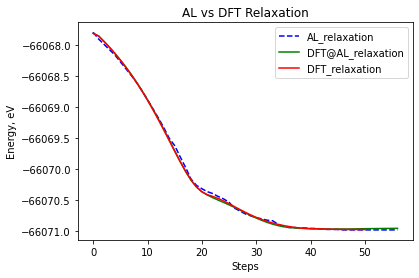

In [0]:
# Visualize Results
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
%matplotlib inline

base_calc = Espresso(pw=500.0, 
                calculation='scf',
                kpts=(4,4,1),
                xc='PBE')

final_ml_traj = ase.io.read("./relax_example_iter_3.traj", ":")
parent_calc_traj = ase.io.read("./true_relax.traj", ":")

#Compute ML predicted energies
ml_relaxation_energies = [image.get_potential_energy() for image in final_ml_traj]
#Compute actual energies for ML predicted structures
parent_evaluated_ml_energies = [copy.copy(base_calc).get_potential_energy(image) for image in final_ml_traj]
#Compute actual energies for parent relaxation structures
parent_relaxation_energies = [image.get_potential_energy() for image in parent_calc_traj]
ml_steps = range(len(final_ml_traj))
parent_steps = range(len(parent_calc_traj))

plt.plot(ml_steps, ml_relaxation_energies, '--b', label='AL_relaxation')
plt.plot(ml_steps, parent_evaluated_ml_energies, '-g', label='DFT@AL_relaxation')
plt.plot(parent_steps, parent_relaxation_energies, '-r', label='DFT_relaxation')
plt.xlabel("Steps")
plt.ylabel("Energy, eV")
plt.title('AL vs DFT Relaxation')
plt.legend()
plt.show()

In [0]:
# Evaluation Metrics
def compute_loss(a, b):
  return np.mean(np.sqrt(np.sum((a - b)**2, axis=1)))

initial_structure = images[0].positions
al_iterations = training_params['al_convergence']['num_iterations']
retrained_samples = training_params['samples_to_retrain']
print(f'Number of AL iterations: {al_iterations}\nNumber of samples/iteration: {retrained_samples}\nTotal # of queries: {al_iterations*retrained_samples}\n')
print(f'Final AL Relaxed Energy: {ml_relaxation_energies[-1]}')
print(f'DFT evaluation at AL structure: {parent_evaluated_ml_energies[-1]}\n')
al_relaxed_structure = final_ml_traj[-1].positions

print(f'Total number of DFT steps: {len(parent_relaxation_energies)}')
print(f'Final DFT Relaxed Energy: {parent_relaxation_energies[-1]}\n')
parent_relaxed_structure = parent_calc_traj[-1].positions


initial_structure_error = compute_loss(initial_structure, parent_relaxed_structure)
relaxed_structure_error = compute_loss(al_relaxed_structure, parent_relaxed_structure)

print(f'Initial structure error: {initial_structure_error}')
print(f'AL relaxed structure error: {relaxed_structure_error}')

Number of AL iterations: 3
Number of samples/iteration: 5
Total # of queries: 15

Final AL Relaxed Energy: -66070.984375
DFT evaluation at AL structure: -66070.95898664904

Total number of DFT steps: 51
Final DFT Relaxed Energy: -66070.97805611626

Initial structure error: 0.15544355343669888
AL relaxed structure error: 0.03448707998004555
